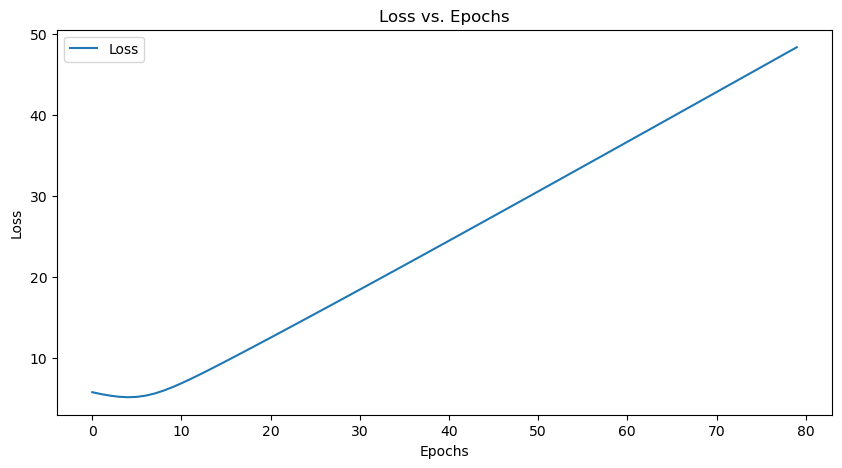

Predictions:
of
Word 'a' is out of vocabulary. Skipping.
None
of
Accuracy: 14.81%


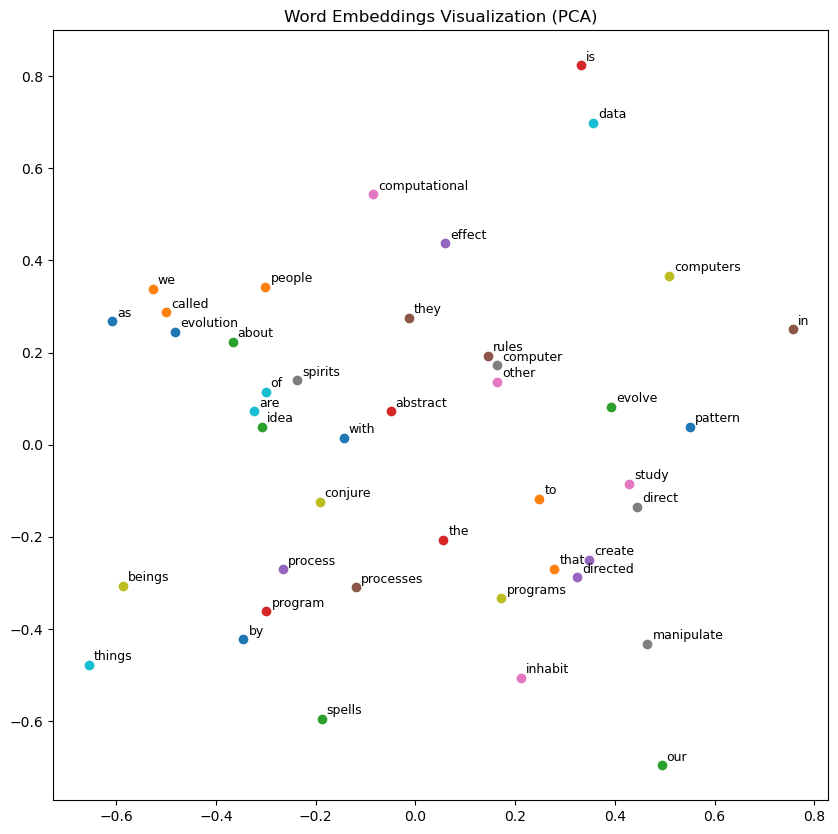

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import re

# Data Preparation
sentences = '''We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.'''

# Clean the data: remove special characters, convert to lowercase
sentences = re.sub('[^A-Za-z0-9 ]+', ' ', sentences).lower()

# Remove 1-letter words and split into words
sentences = re.sub(r'\b\w\b', '', sentences).strip()
words = sentences.split()

# Vocabulary and word mappings
vocab = set(words)
vocab_size = len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

# Model parameters
embed_dim = 10
context_size = 2

# Generate training data
data = []
for i in range(context_size, len(words) - context_size):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))

# Embeddings initialization
embeddings = np.random.random_sample((vocab_size, embed_dim))

# Linear model
def linear(m, theta):
    w = theta
    return m.dot(w)

# Log softmax + Negative Log Likelihood Loss (Cross Entropy)
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum() / len(out)

# Forward pass function
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    return m, n, o

# Backward function
def backward(preds, theta, target_idxs):
    m, n, o = preds
    dlog = np.zeros_like(n)
    dlog[0, target_idxs] -= 1
    dw = m.T.dot(dlog)
    return dw

# Optimize function
def optimize(theta, grad, lr=0.03):
    theta -= lr * grad
    return theta

# Training process
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

epoch_losses = {}
for epoch in range(80):
    losses = []
    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)
        target_idx = word_to_ix[target]
        loss = NLLLoss(preds[-1], np.array([target_idx]))
        losses.append(loss)
        grad = backward(preds, theta, target_idx)
        theta = optimize(theta, grad)
    epoch_losses[epoch] = losses

# Plot loss vs. epochs
epochs = np.arange(80)
average_losses = [np.mean(epoch_losses[epoch]) for epoch in epochs]

plt.figure(figsize=(10, 5))
plt.plot(epochs, average_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

# # Prediction function
# def predict(context_words):
#     context_idxs = np.array([word_to_ix[w] for w in context_words])
#     preds = forward(context_idxs, theta)
#     word = ix_to_word[np.argmax(preds[-1])]
#     return word

# Prediction function with OOV handling
def predict(context_words):
    context_idxs = []
    for w in context_words:
        if w in word_to_ix:
            context_idxs.append(word_to_ix[w])
        else:
            print(f"Word '{w}' is out of vocabulary. Skipping.")
            return None  # Handle OOV word
    
    context_idxs = np.array(context_idxs)
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    return word


# Accuracy function
def accuracy():
    correct = 0
    for context, target in data:
        if predict(context) == target:
            correct += 1
    return correct / len(data)

# Plot word embeddings (first 2 components for visualization)
from sklearn.decomposition import PCA

def plot_embeddings():
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(vocab):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.text(reduced_embeddings[i, 0]+0.01, reduced_embeddings[i, 1]+0.01, word, fontsize=9)
    plt.title("Word Embeddings Visualization (PCA)")
    plt.show()

# Predict example sentences
print("Predictions:")
print(predict(['we', 'are', 'to', 'study']))  # Example 1
print(predict(['the', 'idea', 'of', 'a']))   # Example 2
print(predict(['abstract', 'beings', 'that', 'inhabit']))  # Example 3

# Display accuracy
print(f'Accuracy: {accuracy() * 100:.2f}%')

# Plot word embeddings
plot_embeddings()
